In [1]:
#!pip install scikit-learn

In [2]:
#!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import time
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from multiprocessing import Pool, cpu_count
import requests
import aiohttp
import asyncio
from datetime import date

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [16]:
# Реальные средние температуры (примерные данные) для городов по сезонам
seasonal_temperatures = {
    "New York": {"winter": 0, "spring": 10, "summer": 25, "autumn": 15},
    "London": {"winter": 5, "spring": 11, "summer": 18, "autumn": 12},
    "Paris": {"winter": 4, "spring": 12, "summer": 20, "autumn": 13},
    "Tokyo": {"winter": 6, "spring": 15, "summer": 27, "autumn": 18},
    "Moscow": {"winter": -10, "spring": 5, "summer": 18, "autumn": 8},
    "Sydney": {"winter": 12, "spring": 18, "summer": 25, "autumn": 20},
    "Berlin": {"winter": 0, "spring": 10, "summer": 20, "autumn": 11},
    "Beijing": {"winter": -2, "spring": 13, "summer": 27, "autumn": 16},
    "Rio de Janeiro": {"winter": 20, "spring": 25, "summer": 30, "autumn": 25},
    "Dubai": {"winter": 20, "spring": 30, "summer": 40, "autumn": 30},
    "Los Angeles": {"winter": 15, "spring": 18, "summer": 25, "autumn": 20},
    "Singapore": {"winter": 27, "spring": 28, "summer": 28, "autumn": 27},
    "Mumbai": {"winter": 25, "spring": 30, "summer": 35, "autumn": 30},
    "Cairo": {"winter": 15, "spring": 25, "summer": 35, "autumn": 25},
    "Mexico City": {"winter": 12, "spring": 18, "summer": 20, "autumn": 15},
}

# Сопоставление месяцев с сезонами
month_to_season = {12: "winter", 1: "winter", 2: "winter",
                   3: "spring", 4: "spring", 5: "spring",
                   6: "summer", 7: "summer", 8: "summer",
                   9: "autumn", 10: "autumn", 11: "autumn"}

# Генерация данных о температуре
def generate_realistic_temperature_data(cities, num_years=10):
    dates = pd.date_range(start="2010-01-01", periods=365 * num_years, freq="D")
    data = []

    for city in cities:
        for date in dates:
            season = month_to_season[date.month]
            mean_temp = seasonal_temperatures[city][season]
            # Добавляем случайное отклонение
            temperature = np.random.normal(loc=mean_temp, scale=5)
            data.append({"city": city, "timestamp": date, "temperature": temperature})

    df = pd.DataFrame(data)
    df['season'] = df['timestamp'].dt.month.map(lambda x: month_to_season[x])
    return df

# Генерация данных
data = generate_realistic_temperature_data(list(seasonal_temperatures.keys()))
data.to_csv('temperature_data.csv', index=False)

## 1. Анализ исторических данных

In [17]:
window_size = 30 

In [18]:
data['rolling_mean'] = data.groupby(['city', 'season'])['temperature'] \
        .rolling(window=window_size, min_periods=1) \
        .mean().reset_index(level=[0, 1], drop=True)

std_stats = data.groupby(['city', 'season'])['temperature'].agg(['std', 'min', 'max', 'median']).reset_index()
mean_stats = data.groupby(['city', 'season'])['rolling_mean'].agg(['mean']).reset_index()

data = data.merge(std_stats, on=['city', 'season'], how='left', suffixes=('', '_drop'))[
        ['city', 'timestamp', 'temperature', 'season', 'rolling_mean', 'std', 'min', 'max', 'median']]

data = data.merge(mean_stats, on=['city', 'season'], how='left', suffixes=('', '_drop'))[
        ['city', 'timestamp', 'temperature', 'season', 'rolling_mean', 'mean', 'std', 'min', 'max', 'median']]

# определяем аномальные температуры
data['is_anomaly'] = (data['temperature'] > (data['rolling_mean'] + 2 * data['std'])) | \
                         (data['temperature'] < (data['rolling_mean'] - 2 * data['std']))

In [19]:
data.head(10)

,city,timestamp,temperature,season,rolling_mean,mean,std,min,max,median,is_anomaly
0,New York,2010-01-01,-6.668316,winter,-6.668316,0.13646,4.956988,-15.672315,14.533784,0.12472,False
1,New York,2010-01-02,3.007174,winter,-1.830571,0.13646,4.956988,-15.672315,14.533784,0.12472,False
2,New York,2010-01-03,3.859373,winter,0.066077,0.13646,4.956988,-15.672315,14.533784,0.12472,False
3,New York,2010-01-04,-6.950286,winter,-1.688014,0.13646,4.956988,-15.672315,14.533784,0.12472,False
4,New York,2010-01-05,-1.350585,winter,-1.620528,0.13646,4.956988,-15.672315,14.533784,0.12472,False
5,New York,2010-01-06,2.837686,winter,-0.877492,0.13646,4.956988,-15.672315,14.533784,0.12472,False
6,New York,2010-01-07,-1.350246,winter,-0.945029,0.13646,4.956988,-15.672315,14.533784,0.12472,False
7,New York,2010-01-08,2.406349,winter,-0.526106,0.13646,4.956988,-15.672315,14.533784,0.12472,False
8,New York,2010-01-09,-4.850674,winter,-1.006614,0.13646,4.956988,-15.672315,14.533784,0.12472,False
9,New York,2010-01-10,3.771282,winter,-0.528824,0.13646,4.956988,-15.672315,14.533784,0.12472,False


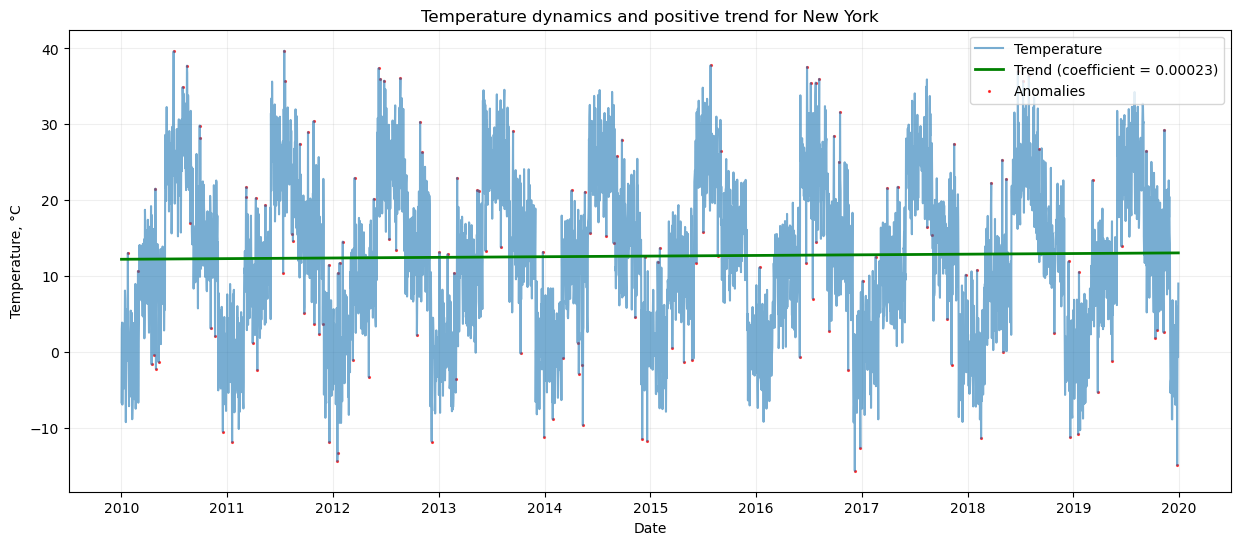

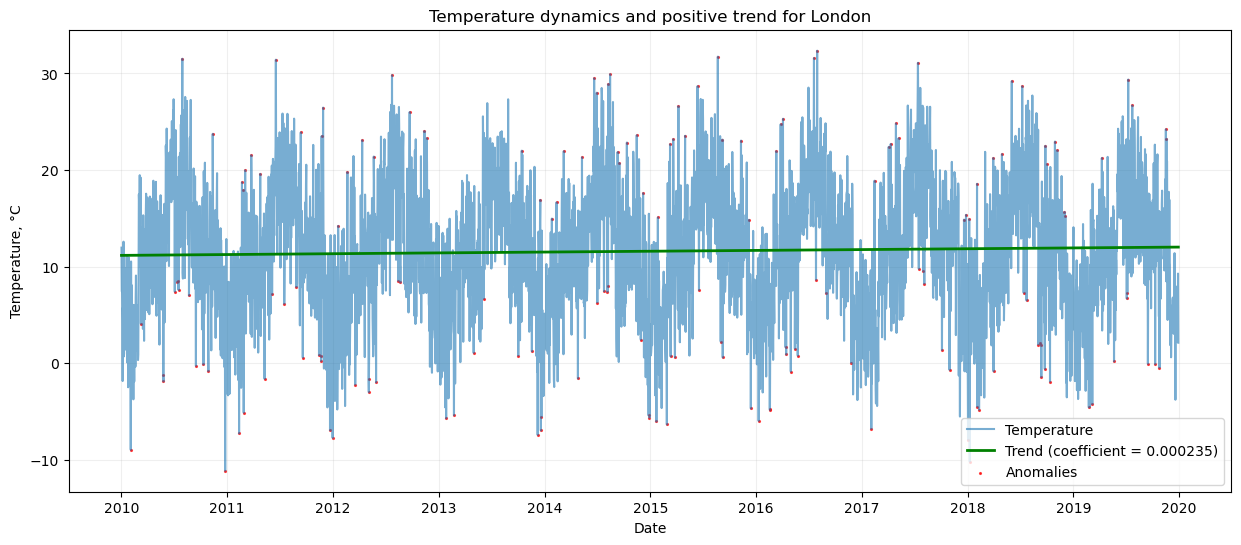

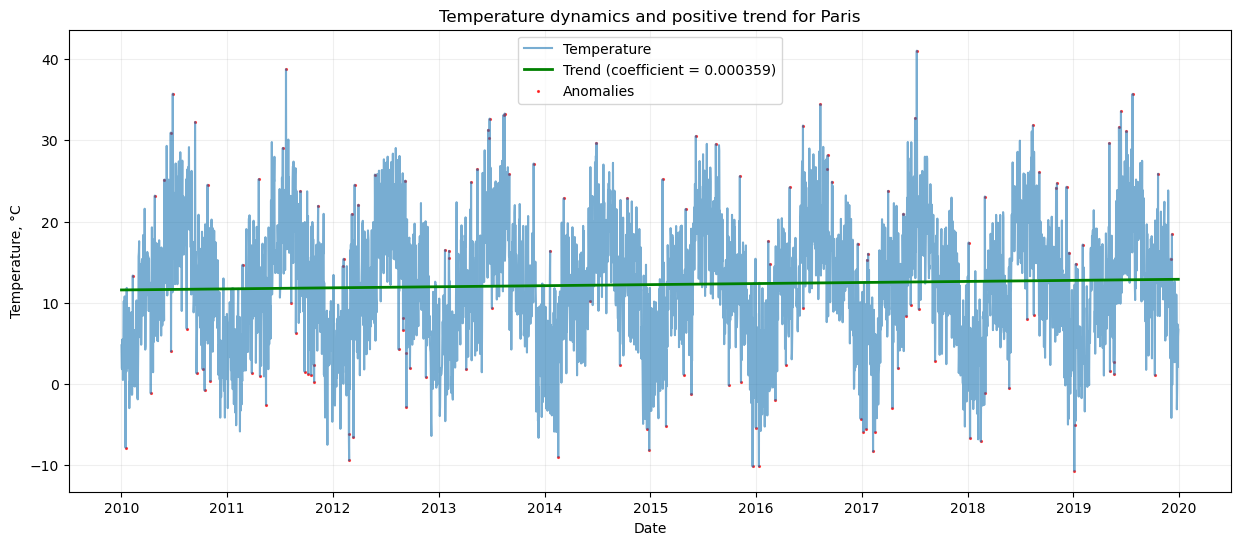

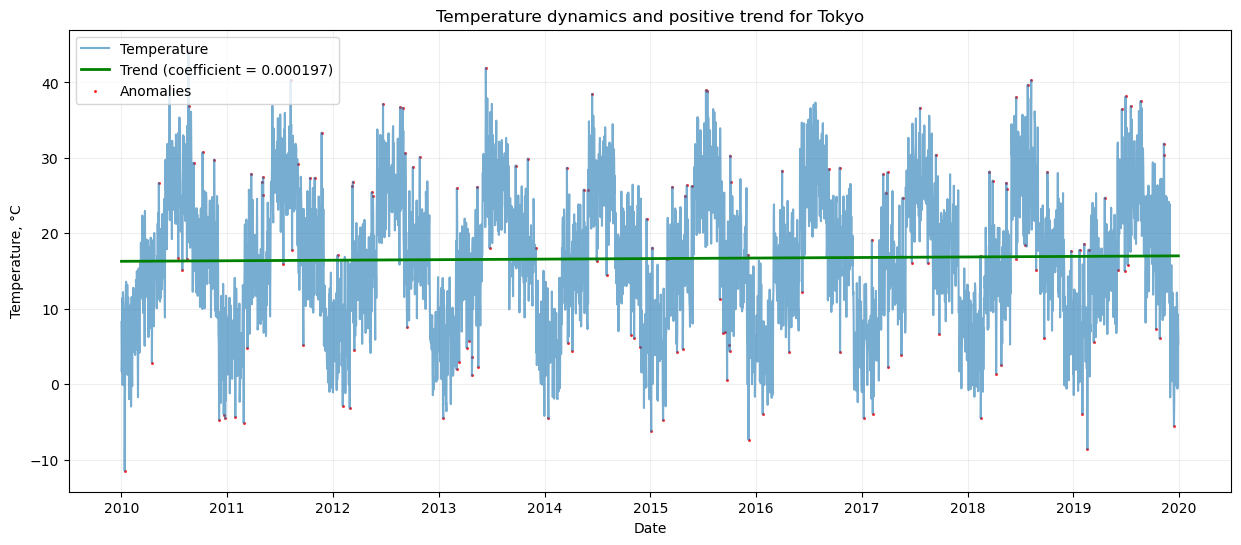

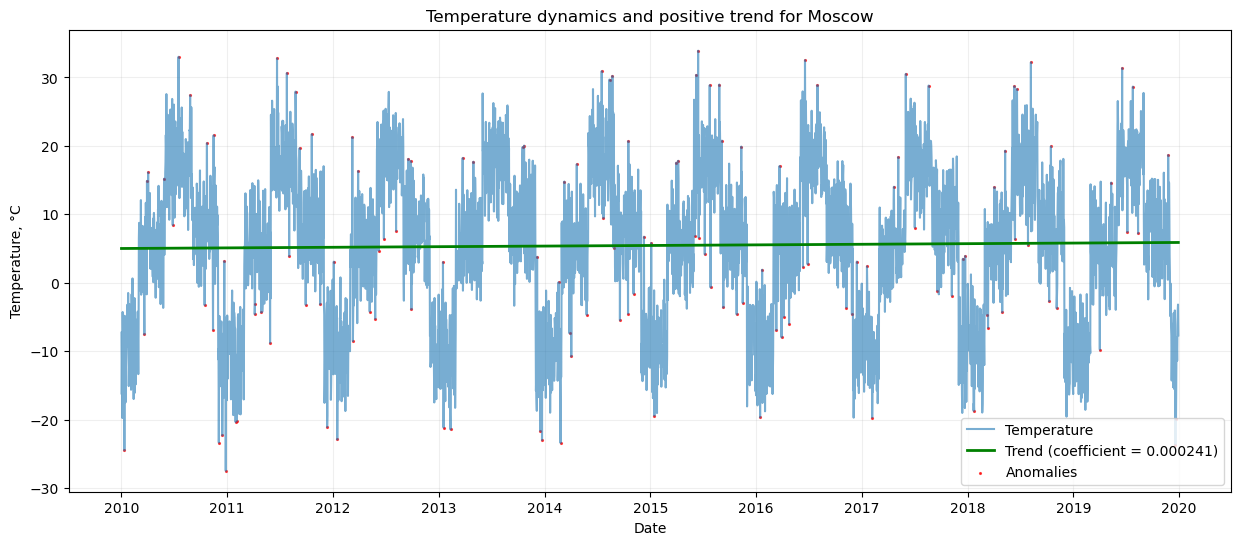

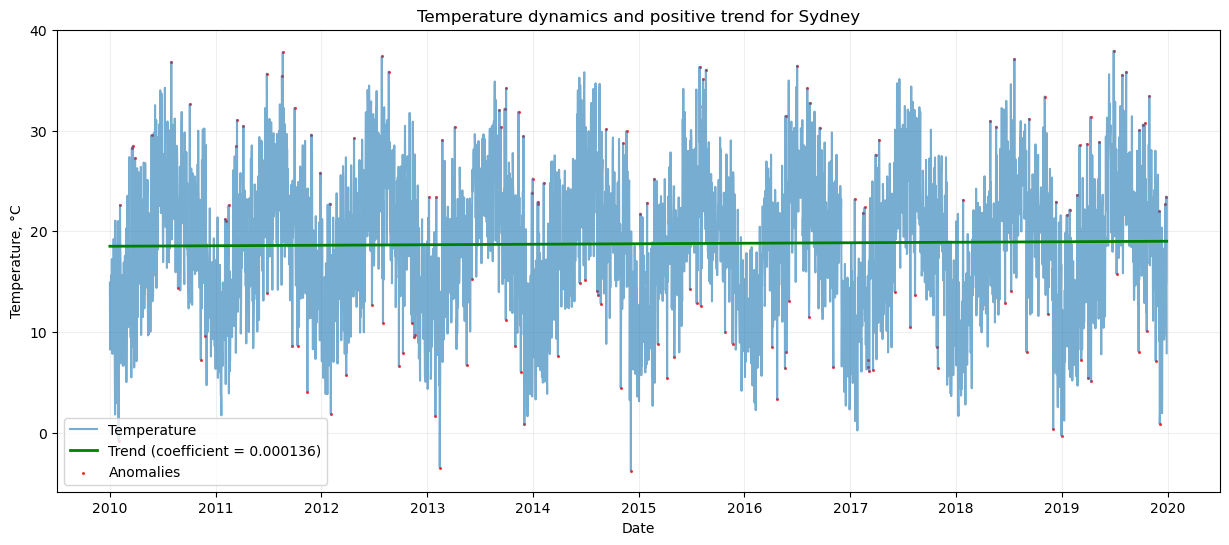

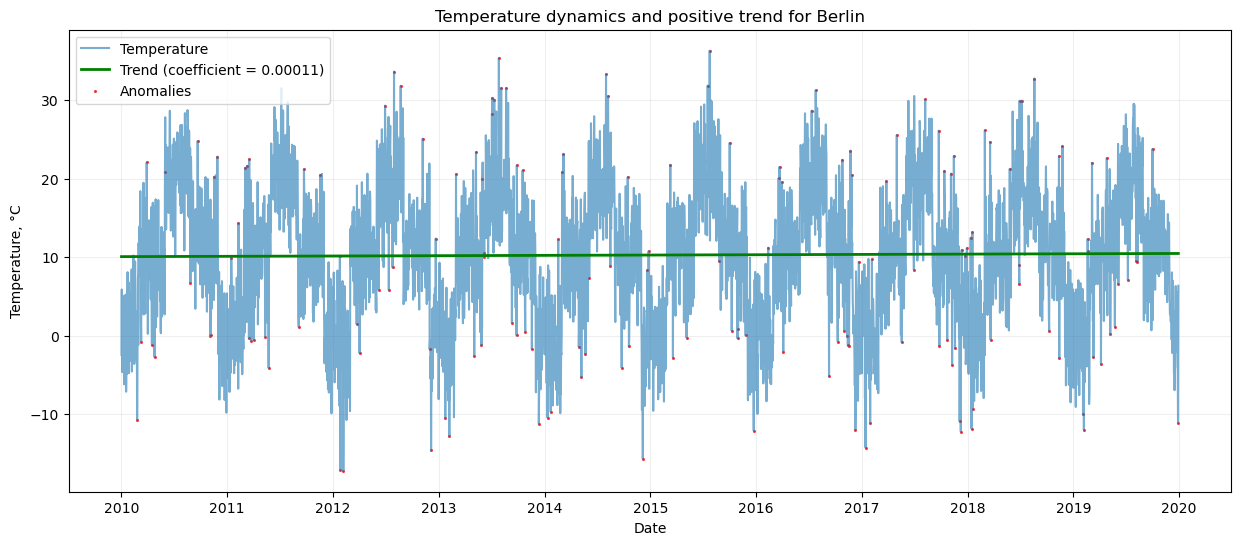

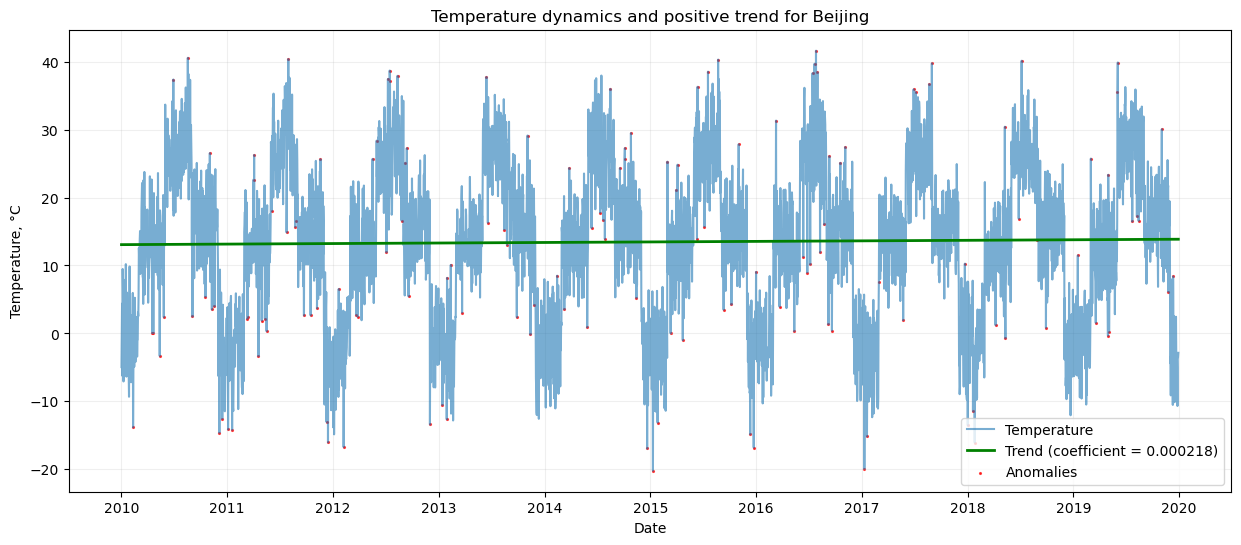

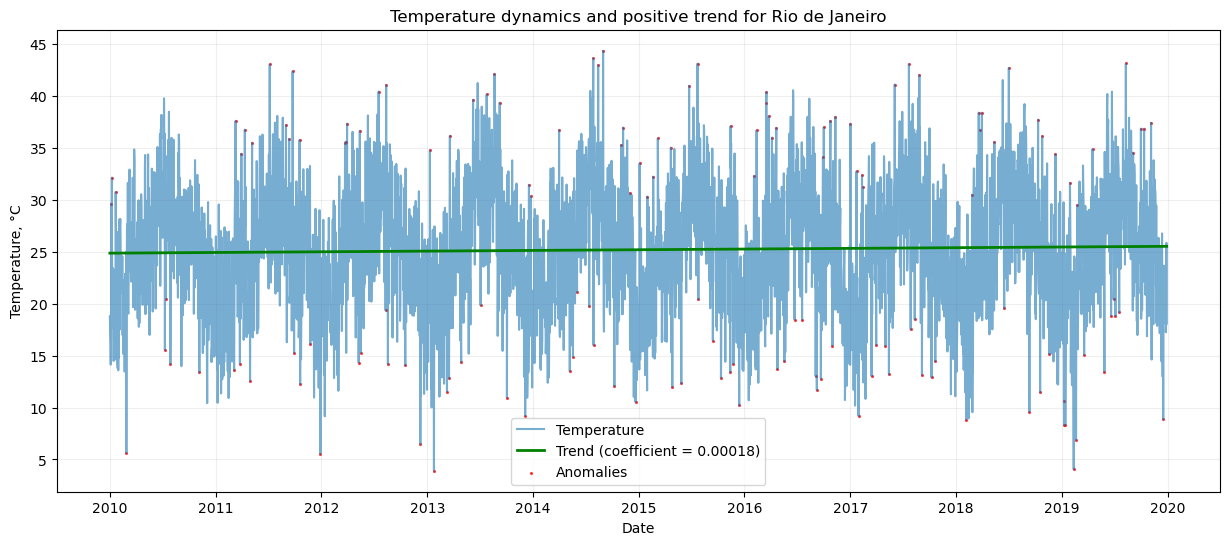

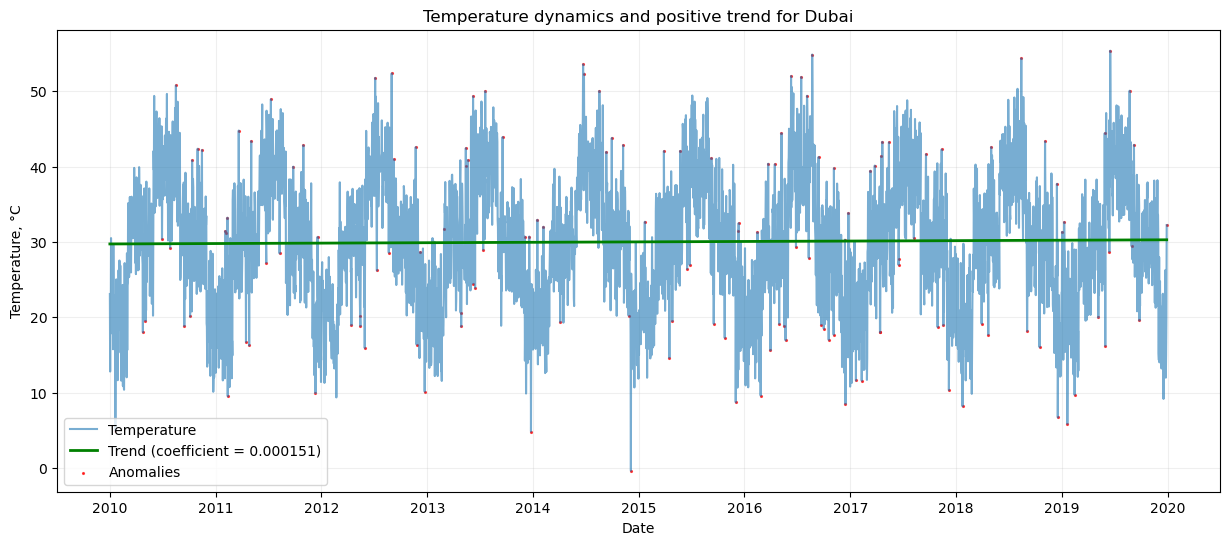

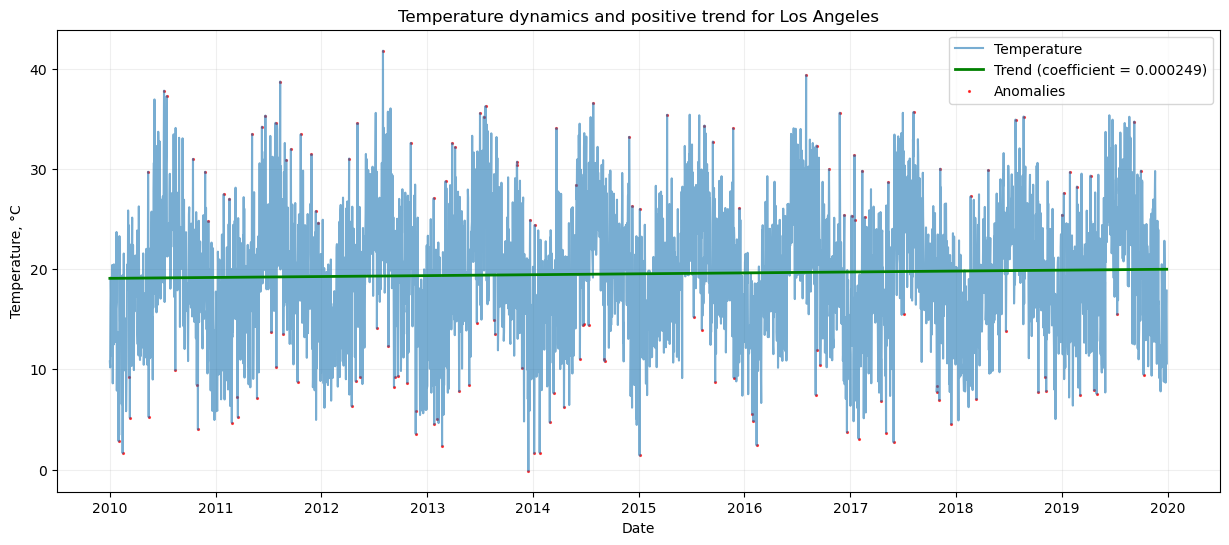

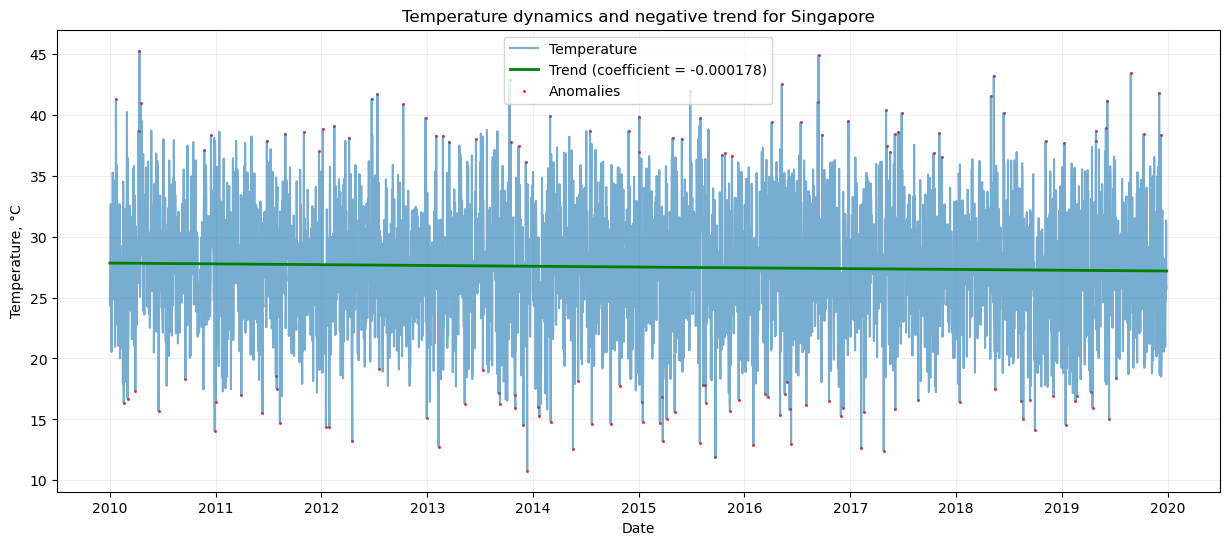

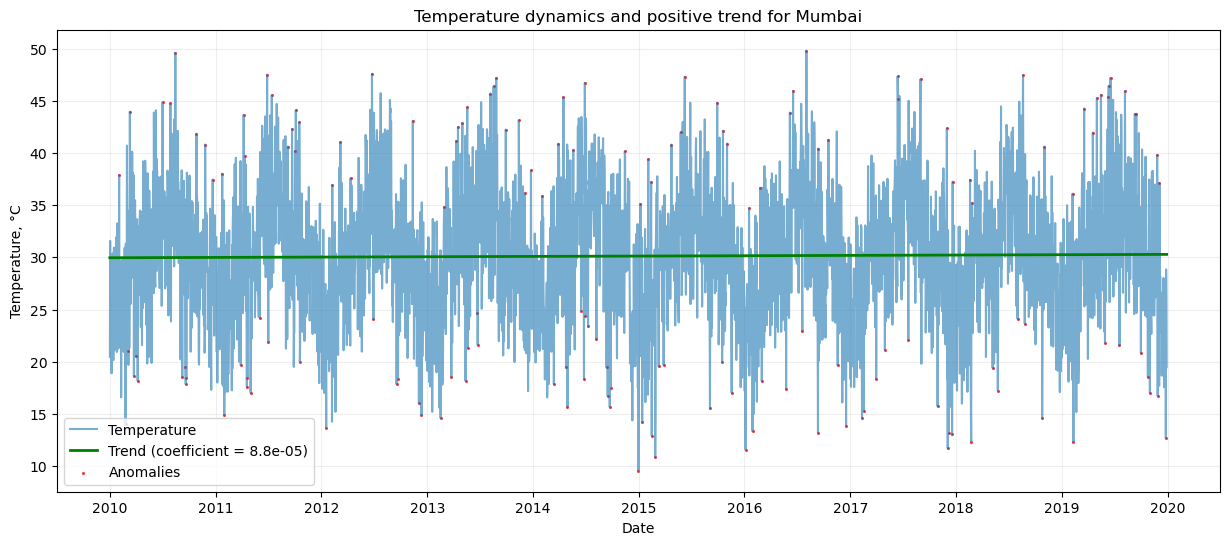

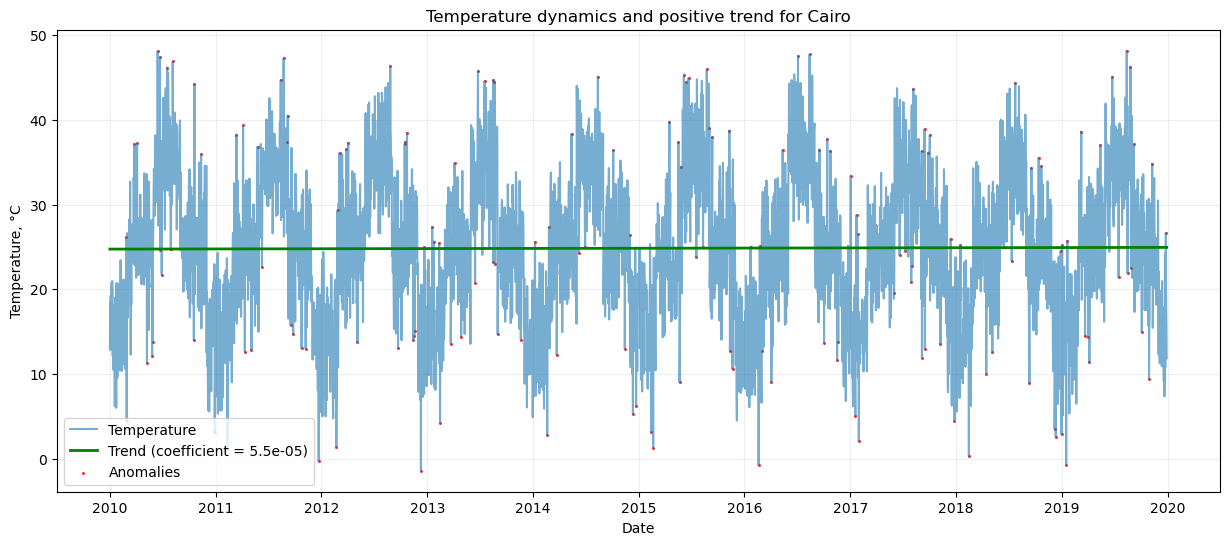

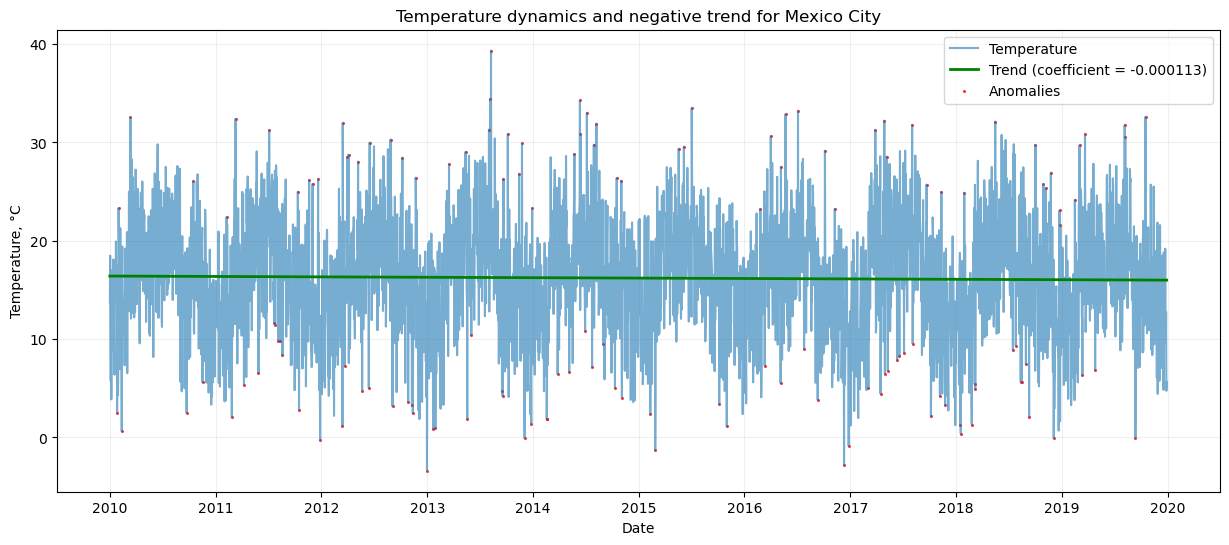

In [20]:
trend_lines = {}

for city in data['city'].unique():
    city_data = data[data['city'] == city].copy() 
    
    city_data['days'] = (city_data['timestamp'] - city_data['timestamp'].min()).dt.days
    
    model = LinearRegression()
    model.fit(city_data[['days']], city_data['temperature'])
    
    # предсказание долгосрочного тренда
    city_data['trend'] = model.predict(city_data[['days']])

    # сохраняем коэффициент тренда
    trend_coef = round(model.coef_[0], 6)
    
    trend_lines = city_data[['timestamp', 'temperature', 'trend']]

    if trend_coef < 0:
        title_line = f"Temperature dynamics and negative trend for {city}"
    elif trend_coef > 0:
        title_line = f"Temperature dynamics and positive trend for {city}"
    else:
        title_line = f"Temperature dynamics and neutral trend for {city}"

    plt.figure(figsize=(15, 6))
    plt.plot(city_data['timestamp'], city_data['temperature'], label='Temperature', alpha=0.6)
    plt.plot(city_data['timestamp'], city_data['trend'], label=f'Trend (coefficient = {trend_coef})', color='green', linewidth=2)

    anomaly_points = city_data[city_data['is_anomaly']]
    plt.scatter(
        anomaly_points['timestamp'], anomaly_points['temperature'],
        color='red', label='Anomalies', alpha=0.7, s=1.6
    )
    
    plt.title(title_line)
    plt.xlabel("Date")
    plt.ylabel("Temperature, °C")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

In [21]:
# выведем аномалии
anomalies = data[data['is_anomaly'] == True]
print("Detected anomalies:")
print(anomalies[['timestamp', 'city', 'season', 'temperature', 'mean', 'std']])

Detected anomalies:
       timestamp         city  season  temperature       mean       std
22    2010-01-23     New York  winter    13.045539   0.136460  4.956988
57    2010-02-27     New York  winter    10.650591   0.136460  4.956988
104   2010-04-15     New York  spring    -1.658727   9.906689  4.943544
113   2010-04-24     New York  spring    -0.367350   9.906689  4.943544
117   2010-04-28     New York  spring    21.520431   9.906689  4.943544
...          ...          ...     ...          ...        ...       ...
54502 2019-04-26  Mexico City  spring     6.845508  18.098038  5.033252
54604 2019-08-06  Mexico City  summer    31.771388  19.878608  4.845964
54606 2019-08-08  Mexico City  summer    30.573813  19.878608  4.845964
54641 2019-09-12  Mexico City  autumn    -0.023078  14.804461  5.041421
54676 2019-10-17  Mexico City  autumn    32.592417  14.804461  5.041421

[2262 rows x 6 columns]


In [22]:
def analyze_city_data(data):
    data = data.copy() 
    
    data['rolling_mean'] = data.groupby(['city', 'season'])['temperature'] \
        .rolling(window=window_size, min_periods=1) \
        .mean().reset_index(level=[0, 1], drop=True)

    std_stats = data.groupby(['city', 'season'])['temperature'].agg(['std', 'min', 'max', 'median']).reset_index()
    mean_stats = data.groupby(['city', 'season'])['rolling_mean'].agg(['mean']).reset_index()

    data = data.merge(std_stats, on=['city', 'season'], how='left', suffixes=('', '_drop'))[
        ['city', 'timestamp', 'temperature', 'season', 'rolling_mean', 'std', 'min', 'max', 'median']]

    data = data.merge(mean_stats, on=['city', 'season'], how='left', suffixes=('', '_drop'))[
        ['city', 'timestamp', 'temperature', 'season', 'rolling_mean', 'mean', 'std', 'min', 'max', 'median']]

    data['is_anomaly'] = (data['temperature'] > (data['rolling_mean'] + 2 * data['std'])) | \
                         (data['temperature'] < (data['rolling_mean'] - 2 * data['std']))
    
    return data

In [23]:
# последовательное выполнение 

def sequential_analysis(data):
    result_frames = []
    for city in data['city'].unique():
        city_data = data[data['city'] == city].copy()
        analyzed_data = analyze_city_data(city_data)
        result_frames.append(analyzed_data)

    result_df = pd.concat(result_frames, ignore_index=True)
    return result_df

In [24]:
start_time = time.time()
sequential_results = sequential_analysis(data)
end_time = time.time()

print(f"Time without parallelism: {end_time - start_time:.4f} seconds")

Time without parallelism: 0.2644 seconds


In [25]:
# параллельное выполнение (многопоточность)

def parallel_analysis(data):
    with ThreadPoolExecutor() as executor:
        futures = {city: executor.submit(analyze_city_data, data[data['city'] == city]) 
                   for city in data['city'].unique()}
        
        result_frames = [future.result() for future in futures.values()]
    
    result_df = pd.concat(result_frames, ignore_index=True)
    return result_df

In [26]:
start_time = time.time()
parallel_results = parallel_analysis(data)
end_time = time.time()

print(f"Time with parallelism: {end_time - start_time:.4f} seconds")

Time with parallelism: 0.7564 seconds


In [27]:
# второй вариант параллельного выполнения (многопроцессность)

def parallel_analysis_multiprocess(data):
    cities = data['city'].unique()
    
    with Pool(processes=cpu_count()) as pool:
        city_data_list = [data[data['city'] == city].copy() for city in cities]
        results = pool.map(analyze_city_data, city_data_list)

    return pd.concat(results, ignore_index=True)

In [28]:
start_time = time.time()
parallel_results_multiprocess = parallel_analysis_multiprocess(data)
end_time = time.time()

print(f"Time with parallelism: {end_time - start_time:.4f} seconds")

Time with parallelism: 0.4335 seconds


In [29]:
# третий вариант параллельного выполнения (многопроцессность)

def parallel_analysis_multiprocess_futures(data):
    cities = data['city'].unique()
    city_data_list = [data[data['city'] == city].copy() for city in cities]
    results = []
    
    with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
        futures = {executor.submit(analyze_city_data, city_data): city_data for city_data in city_data_list}
        for future in as_completed(futures):
            results.append(future.result())
            
    return pd.concat(results, ignore_index=True)

In [30]:
start_time = time.time()
parallel_results = parallel_analysis_multiprocess_futures(data)
end_time = time.time()

print(f"Time with parallelism: {end_time - start_time:.4f} seconds")

Time with parallelism: 0.4179 seconds


Вариант без распараллеливания получился в 2-3 раза быстрее.

In [49]:
# выведем дополнительно боксплоты на каждый город

def anomalies_detection(data):
    window_size = 30

    data['rolling_mean'] = data.groupby(['city', 'season'])['temperature'] \
        .rolling(window=window_size, min_periods=1) \
        .mean().reset_index(level=[0, 1], drop=True)

    std_stats = data.groupby(['city', 'season'])['temperature'].agg(['std', 'min', 'max', 'median']).reset_index()
    mean_stats = data.groupby(['city', 'season'])['rolling_mean'].agg(['mean']).reset_index()

    data = data.merge(std_stats, on=['city', 'season'], how='left', suffixes=('', '_drop'))[
        ['city', 'timestamp', 'temperature', 'season', 'rolling_mean', 'std', 'min', 'max', 'median']]

    data = data.merge(mean_stats, on=['city', 'season'], how='left', suffixes=('', '_drop'))[
        ['city', 'timestamp', 'temperature', 'season', 'rolling_mean', 'mean', 'std', 'min', 'max', 'median']]

    data['is_anomaly'] = (data['temperature'] > (data['rolling_mean'] + 2 * data['std'])) | \
                         (data['temperature'] < (data['rolling_mean'] - 2 * data['std']))

    return data

def plot_seasonal_boxplot(data, city):
    city_data = data[data['city'] == city].copy()

    city_data = anomalies_detection(city_data)

    plt.figure(figsize=(10, 6))

    sns.boxplot(x='season', y='temperature', data=city_data, palette='Set2', hue='season')

    for season in city_data['season'].unique():
        season_data = city_data[city_data['season'] == season]
        mean = season_data['mean'].iloc[0]
        std = season_data['std'].iloc[0]

        plt.errorbar(
            x=season, y=mean, yerr=std, fmt='o', color='blue', label='Mean ± Std' if season == city_data['season'].unique()[0] else ""
        )

    plt.title(f"Seasonal Temperature Distribution for {city_data['city'].iloc[0]}")
    plt.xlabel("Season")
    plt.ylabel("Temperature, °C")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.2)
    plt.show()

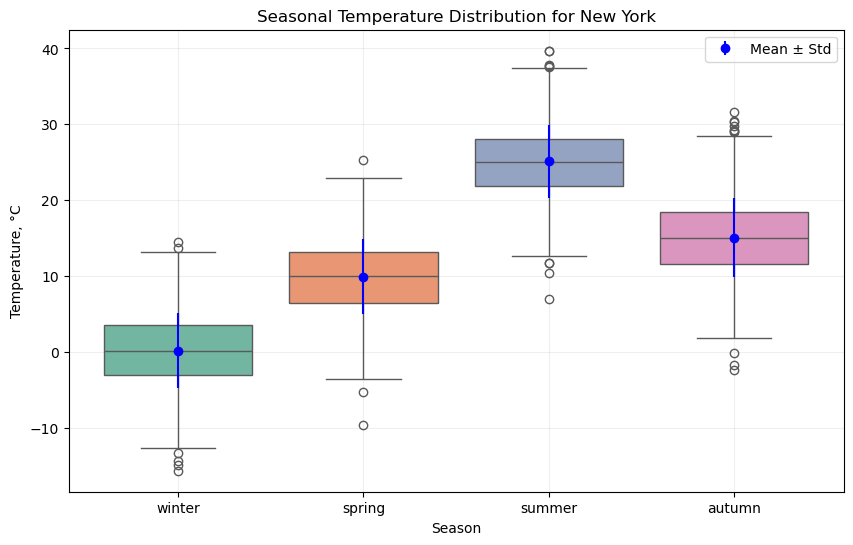

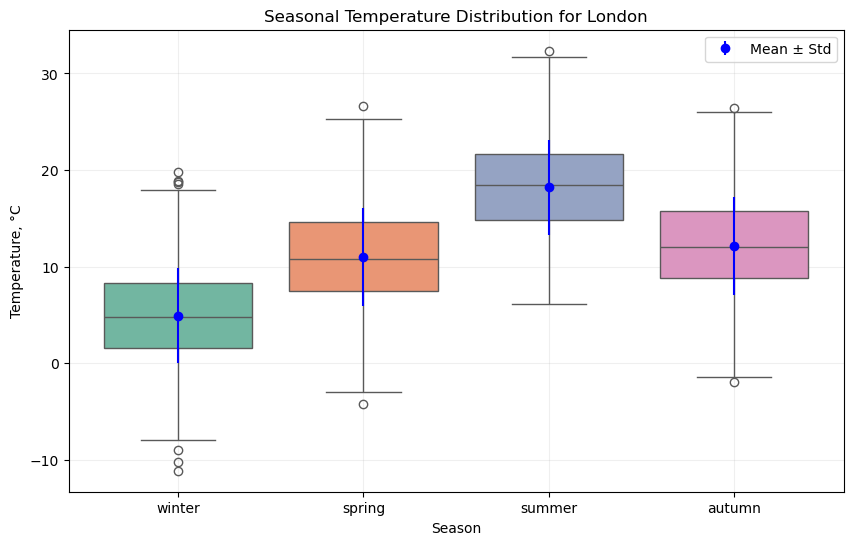

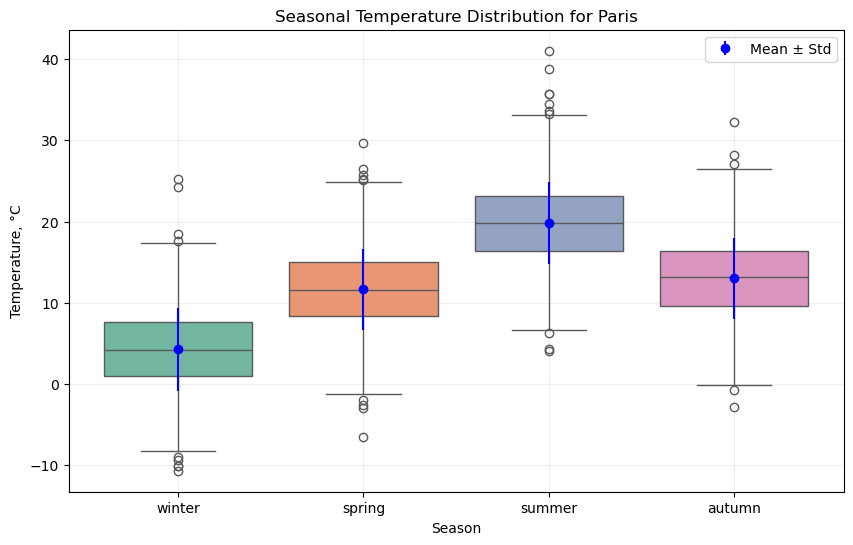

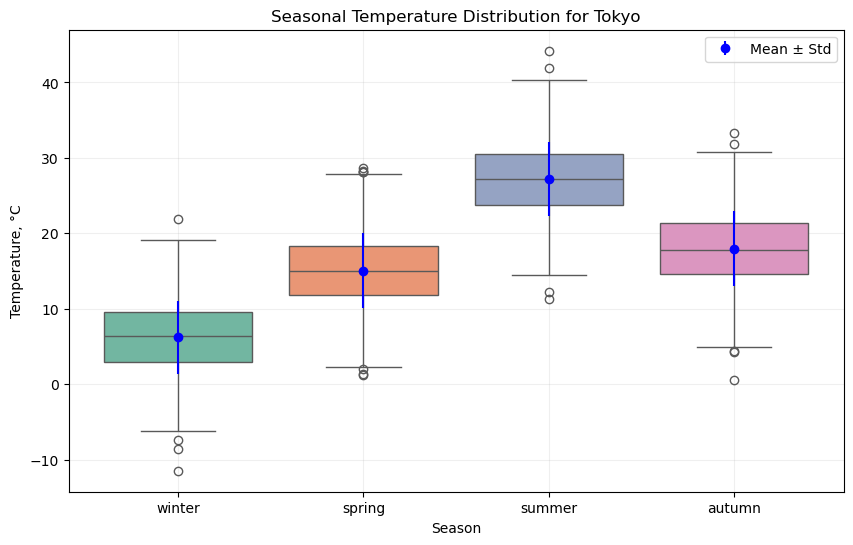

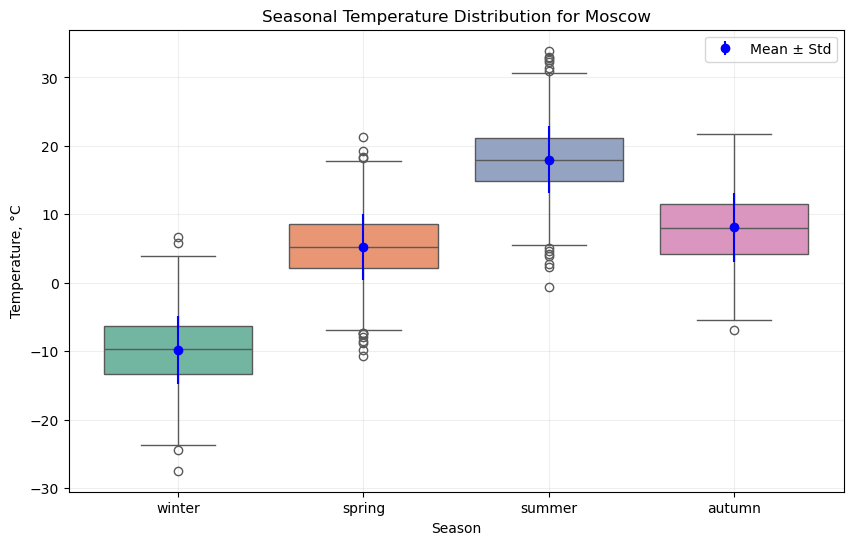

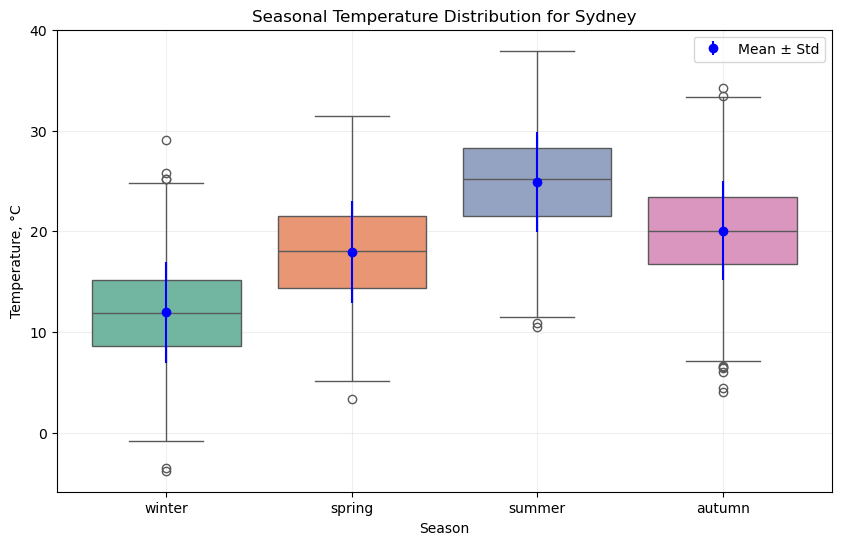

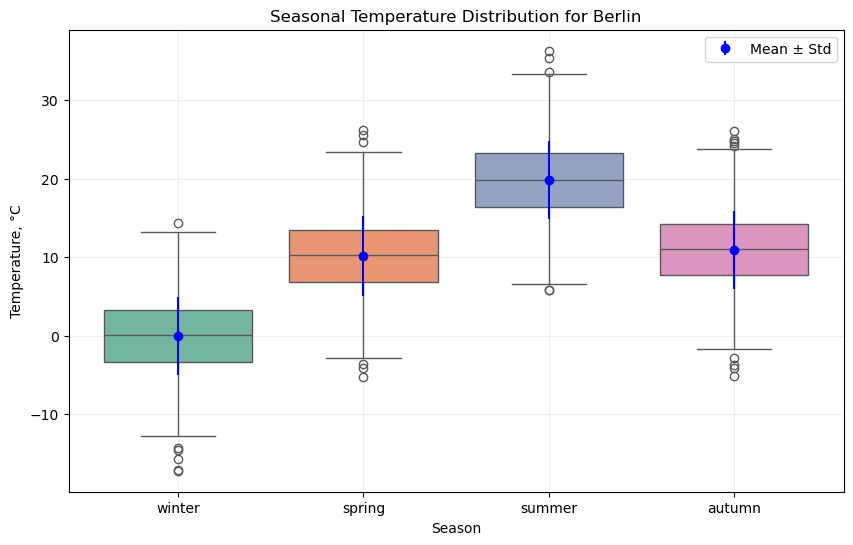

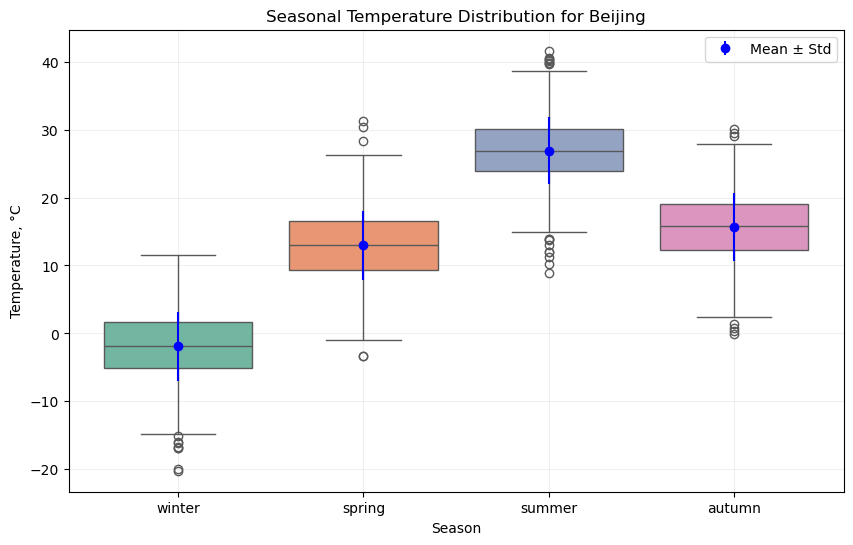

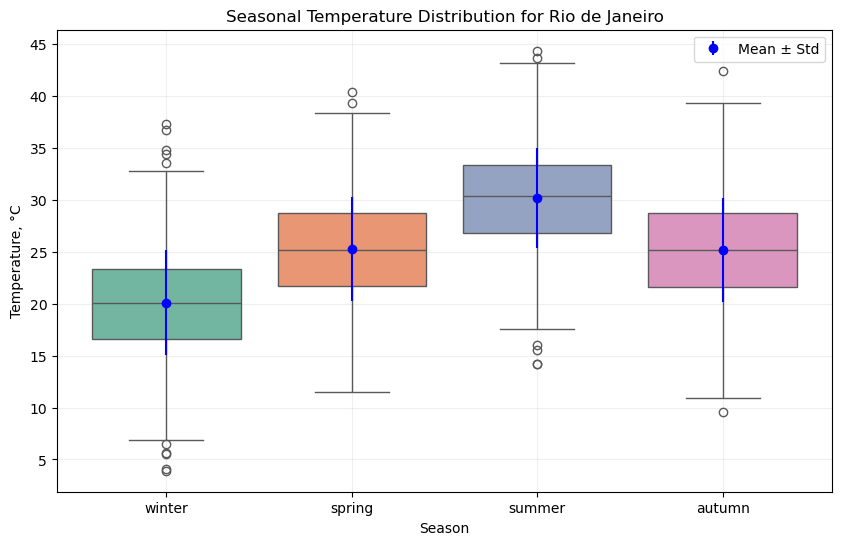

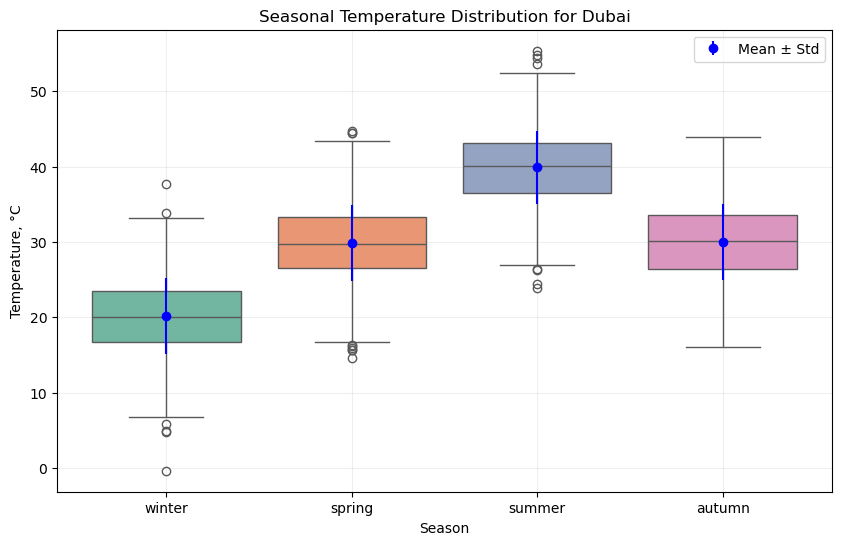

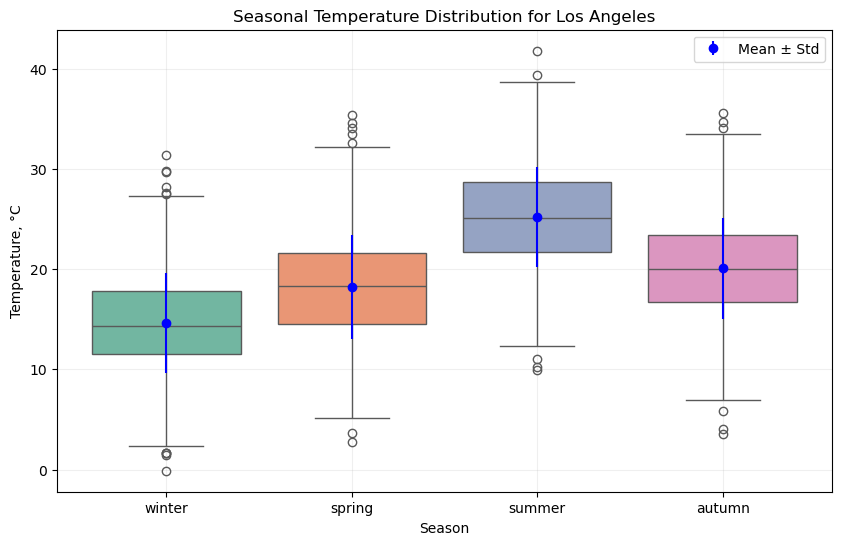

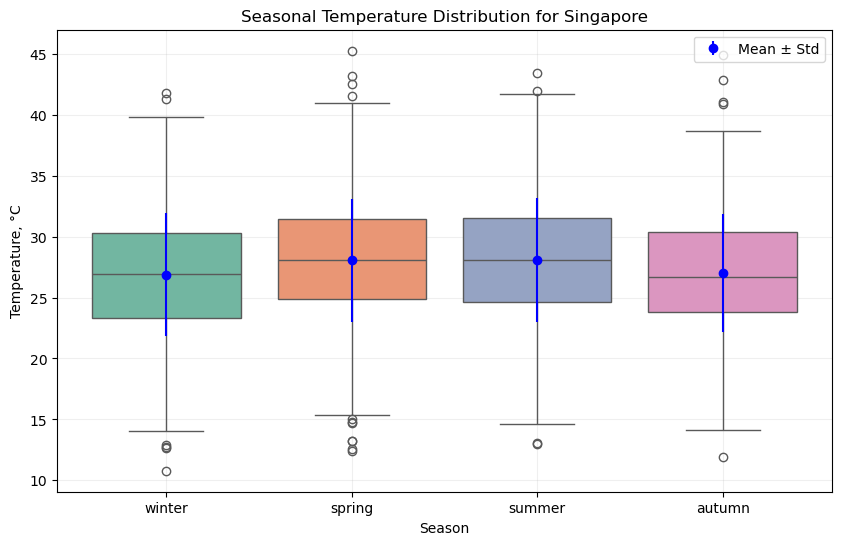

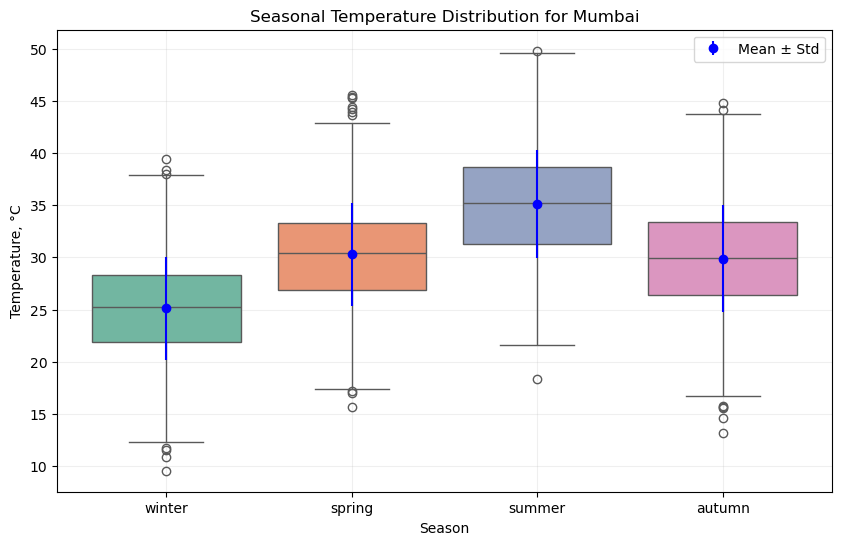

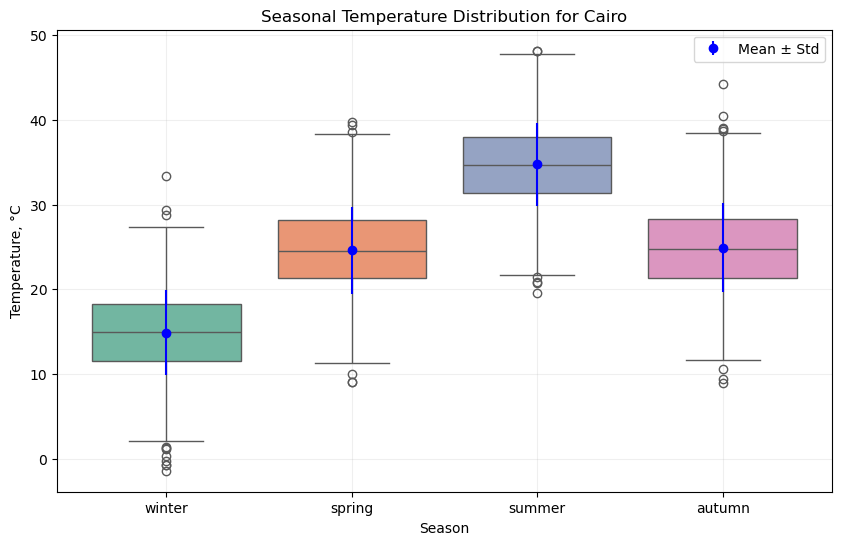

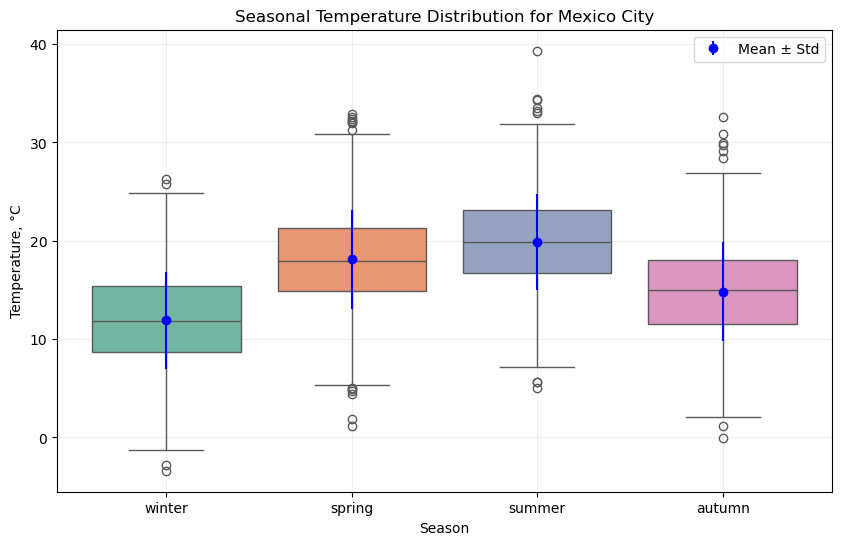

In [50]:
for city in data['city'].unique():
    plot_seasonal_boxplot(data, city)

______________________________________________________________

## 2. Мониторинг текущей температуры

In [31]:
API_KEY = "enter_your_api_key"

BASE_URL = "http://api.openweathermap.org/data/2.5/weather"

In [32]:
def get_current_temperature(city: str):
    params = {
        'q': city,
        'appid': API_KEY,
        'units': 'metric',
        'lang': 'en'              
    }
    
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        data = response.json()
        temperature = data['main']['temp']
        return temperature
    else:
        print(f"Error {response.status_code}: Unable to fetch weather data for {city}.")
        return None

In [33]:
# узнаем, какие температуры в городах на данный момент

cities = data['city'].unique()

temperature_data = []

start_time = time.time()

for city in cities:
    temperature = get_current_temperature(city)
    if temperature is not None:
        temperature_data.append({'city': city, 'current_temperature': temperature})
        
end_time = time.time()

print(f"Time for sync def: {end_time - start_time:.4f} seconds")

temperature_df_sync = pd.DataFrame(temperature_data)

temperature_df_sync

Time for sync def: 2.0779 seconds


,city,current_temperature
0,New York,2.81
1,London,9.04
2,Paris,8.02
3,Tokyo,8.11
4,Moscow,3.13
5,Sydney,17.44
6,Berlin,5.88
7,Beijing,-3.06
8,Rio de Janeiro,32.04
9,Dubai,23.96


In [34]:
temperature_df_sync['season'] = 'winter'

In [35]:
temperature_df_sync = temperature_df_sync.merge(rolling_stats, on=['city', 'season'], how='left')

In [36]:
temperature_df_sync

,city,current_temperature,season,mean,std
0,New York,2.81,winter,-0.120161,0.790031
1,London,9.04,winter,4.832156,0.817176
2,Paris,8.02,winter,4.260866,0.918593
3,Tokyo,8.11,winter,6.188297,0.833770
4,Moscow,3.13,winter,-10.359533,0.836745
5,Sydney,17.44,winter,11.901446,0.949339
6,Berlin,5.88,winter,0.090989,0.906428
7,Beijing,-3.06,winter,-1.822538,0.904606
8,Rio de Janeiro,32.04,winter,20.046018,0.880718
9,Dubai,23.96,winter,19.877837,0.718617


In [37]:
temperature_df_sync['is_anomaly'] = (temperature_df_sync['current_temperature'] > (temperature_df_sync['mean'] + 2 * temperature_df_sync['std'])) | \
                     (temperature_df_sync['current_temperature'] < (temperature_df_sync['mean'] - 2 * temperature_df_sync['std']))

In [38]:
temperature_df_sync.sort_values(by=['is_anomaly', 'city']).reset_index(drop=True)

,city,current_temperature,season,mean,std,is_anomaly
0,Beijing,-3.06,winter,-1.822538,0.904606,False
1,Mexico City,11.73,winter,12.054077,0.886213,False
2,Mumbai,23.99,winter,25.095518,0.905668,False
3,Singapore,26.00,winter,26.926023,0.854279,False
4,Berlin,5.88,winter,0.090989,0.906428,True
5,Cairo,20.42,winter,14.944990,0.986677,True
6,Dubai,23.96,winter,19.877837,0.718617,True
7,London,9.04,winter,4.832156,0.817176,True
8,Los Angeles,12.99,winter,14.814116,0.883006,True
9,Moscow,3.13,winter,-10.359533,0.836745,True


In [39]:
# асинхронное получение температуры
async def get_current_temperature_async(city: str, session: aiohttp.ClientSession):
    params = {
        'q': city,
        'appid': API_KEY,
        'units': 'metric',
        'lang': 'en'
    }
    
    async with session.get(BASE_URL, params=params) as response:
        if response.status == 200:
            data = await response.json()
            temperature = data['main']['temp']
            return temperature
        else:
            print(f"Error {response.status}: Unable to fetch weather data for {city}.")
            return None

async def fetch_temperatures(cities):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for city in cities:
            tasks.append(get_current_temperature_async(city, session))
        
        temperatures = await asyncio.gather(*tasks)
        return temperatures

cities = data['city'].unique()

async def get_all_temperatures():
    temperatures = await fetch_temperatures(cities)
    
    temperature_data = [{'city': city, 'current_temperature': temp} for city, temp in zip(cities, temperatures) if temp is not None]
    temperature_df = pd.DataFrame(temperature_data)
    
    return temperature_df

start_time = time.time()

temperature_df_async = asyncio.run(get_all_temperatures())

end_time = time.time()

print(f"Time for async def: {end_time - start_time:.4f} seconds")

print(temperature_df_async)

Time for async def: 0.1390 seconds
              city  current_temperature
0         New York                 2.81
1           London                 9.04
2            Paris                 8.02
3            Tokyo                 8.11
4           Moscow                 3.13
5           Sydney                17.44
6           Berlin                 5.88
7          Beijing                -3.06
8   Rio de Janeiro                32.04
9            Dubai                23.96
10     Los Angeles                12.99
11       Singapore                26.00
12          Mumbai                23.99
13           Cairo                20.42
14     Mexico City                11.73


In [51]:
# попробуем что-то похожее по структуре синхронно

def get_current_temperature_sync(city: str):
    params = {
        'q': city,
        'appid': API_KEY,
        'units': 'metric',
        'lang': 'en'
    }
    
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        temperature = data['main']['temp']
        return temperature
    else:
        print(f"Error {response.status_code}: Unable to fetch weather data for {city}.")
        return None

def fetch_temperatures_sync(cities):
    temperatures = []
    for city in cities:
        temp = get_current_temperature_sync(city)
        if temp is not None:
            temperatures.append({'city': city, 'current_temperature': temp})
    return temperatures

cities = data['city'].unique()

start_time = time.time()

temperature_data_sync = fetch_temperatures_sync(cities)
temperature_df_sync = pd.DataFrame(temperature_data_sync)

end_time = time.time()

print(f"Time for sync def: {end_time - start_time:.4f} seconds")
print(temperature_df_sync)

Time for sync def: 2.0621 seconds
              city  current_temperature
0         New York                 2.83
1           London                 9.04
2            Paris                 7.98
3            Tokyo                 8.27
4           Moscow                 3.13
5           Sydney                17.32
6           Berlin                 5.78
7          Beijing                -3.06
8   Rio de Janeiro                34.41
9            Dubai                22.96
10     Los Angeles                12.34
11       Singapore                26.00
12          Mumbai                23.99
13           Cairo                20.42
14     Mexico City                10.53


Разница сильная - асинхронные способ быстрее в 14 раз. В приложении задействую синхронный вариант, так как достаю только один город.